In [1]:
import os

# Why Torch? You'll find the answer in the .md files! 
os.environ["KERAS_BACKEND"] = "torch"

import keras

from dataset.k_fold_dataset_wrapper import KFoldDatasetWrapper
from dataset.dataset_loader import dataset_loader
import keras_tuner
from torch.utils.data import DataLoader
from models.naive_dnn_gen.naive_dnn import NaiveDNNTunableModelFamily
from models.structure.tunable_model_family_hypermodel import TunableModelFamilyHypermodel
from torch.utils.data import DataLoader
import pandas

In [27]:
# Initial steps
hyperparameters = keras_tuner.HyperParameters()
train, test = dataset_loader((128, 128), is_grayscale=False)
dataset_split_controller = KFoldDatasetWrapper(5)
dataset_split_controller.load_data(train)

local_train, validation = dataset_split_controller.get_data_for_fold(0)
train_dataloader = DataLoader(dataset=local_train, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(dataset=validation, batch_size=16, shuffle=True)

# First Space Search
We expect the process to not yield good results as the DNN requires a huge number of neurons to work properly. 

After analizing the results we may consider a second search that is restricted to a smaller set of possible parameters

In [40]:
from keras_tuner import BayesianOptimization
from utils.my_tuner import HistoryDeletingBayesianOptimization

hypermodel = TunableModelFamilyHypermodel((3, 128, 128), NaiveDNNTunableModelFamily())

# Our model uses SGD
hyperparameters.Fixed("lr", 1e-4)
hyperparameters.Fixed("momentum", 0.9)

hyperparameters.Fixed("layers", 3)
# I expect the tuner to find better models without dropout as dropout learning takes usually empircally longer.
# We hope to find at least one structure
tuner = HistoryDeletingBayesianOptimization(
    hypermodel,
    hyperparameters=hyperparameters,
    objective='val_loss',
    tune_new_entries=True,
    overwrite=False,
    directory="dnn-search",
    max_trials=15,
    project_name="three-layers"
)

In [42]:
# todo override on_epoch_end to write info of it
tuner.search(train_dataloader, epochs=22, validation_data=validation_dataloader,
             callbacks=[keras.callbacks.CSVLogger("dnn-search/two-layers/search.log", separator=",", append=True)])

Trial 15 Complete [00h 19m 52s]
val_loss: 0.46990901231765747

Best val_loss So Far: 0.4633373022079468
Total elapsed time: 04h 49m 36s


In [44]:
tuner.results_summary(5)  # Top 5
tuner.get_best_hyperparameters(5)


Results summary
Results in dnn-search/three-layers
Showing 5 best trials
Objective(name="val_loss", direction="min")

Trial 12 summary
Hyperparameters:
lr: 0.0001
momentum: 0.9
layers: 3
units_0: 1024
dropout_0: False
units_1: 32
dropout_1: False
units_2: 128
Score: 0.4633373022079468

Trial 09 summary
Hyperparameters:
lr: 0.0001
momentum: 0.9
layers: 3
units_0: 512
dropout_0: False
units_1: 256
dropout_1: False
units_2: 256
Score: 0.46887969970703125

Trial 14 summary
Hyperparameters:
lr: 0.0001
momentum: 0.9
layers: 3
units_0: 2048
dropout_0: True
units_1: 128
dropout_1: False
units_2: 32
Score: 0.46990901231765747

Trial 13 summary
Hyperparameters:
lr: 0.0001
momentum: 0.9
layers: 3
units_0: 512
dropout_0: False
units_1: 128
dropout_1: True
units_2: 256
Score: 0.4733459949493408

Trial 07 summary
Hyperparameters:
lr: 0.0001
momentum: 0.9
layers: 3
units_0: 256
dropout_0: False
units_1: 1024
dropout_1: False
units_2: 1024
Score: 0.4761548936367035


In [31]:
# The top 5 behave kinda bad actually but let's try to train them via Early Stopping for a longer time and see how good they generalize.
# We try with a model that has dropout which typically requires more time to converge
train_model = NaiveDNNTunableModelFamily()
train_model.load_parameters(tuner.get_best_hyperparameters(5)[3])

train_dataloader = DataLoader(dataset=train, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(dataset=test, batch_size=16, shuffle=True)

fine_tune_model = train_model.make_model((3, 128, 128))
train_model.compile_model(fine_tune_model, keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9, nesterov=True))

model_history = fine_tune_model.fit(
    train_dataloader, validation_data=validation_dataloader, epochs=100, callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='min')
    ]
)


Epoch 1/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 53s 180ms/step - accuracy: 0.6031 - loss: 0.6811 - val_accuracy: 0.6816 - val_loss: 0.5857
Epoch 2/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 53s 180ms/step - accuracy: 0.6641 - loss: 0.6083 - val_accuracy: 0.7356 - val_loss: 0.5537
Epoch 3/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 53s 179ms/step - accuracy: 0.6977 - loss: 0.5836 - val_accuracy: 0.6943 - val_loss: 0.5848
Epoch 4/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 54s 182ms/step - accuracy: 0.7172 - loss: 0.5563 - val_accuracy: 0.7196 - val_loss: 0.5656
Epoch 5/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 53s 180ms/step - accuracy: 0.7281 - loss: 0.5320 - val_accuracy: 0.7466 - val_loss: 0.5308
Epoch 6/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 53s 179ms/step - accuracy: 0.7497 - loss: 0.5113 - val_accuracy: 0.7551 - val_loss: 0.5030
Epoch 7/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 55s 184ms/step - accuracy: 0.7564 - loss: 0.5018 - val_accuracy: 0.7576 - val_loss: 0.4982
Epoch 8/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 53s 178ms/step - accuracy: 0.7648 -

<Axes: >

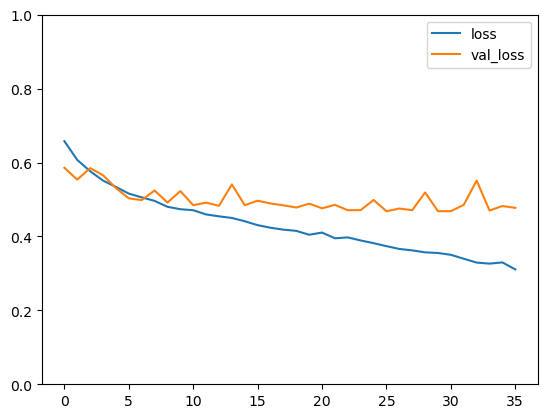

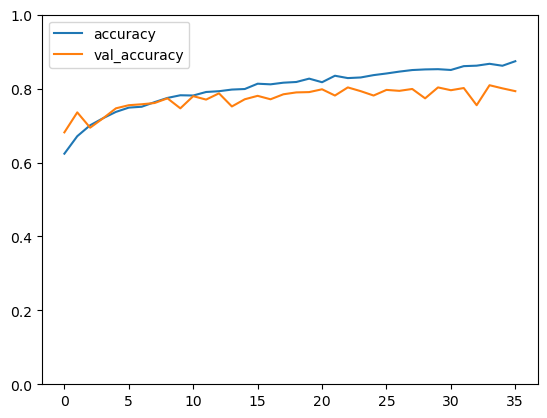

In [38]:
import pandas
metrics_df1 = pandas.DataFrame(model_history.history)
metrics_df1[["loss", "val_loss"]].plot(ylim=(0, 1))
metrics_df1[["accuracy", "val_accuracy"]].plot(ylim=(0, 1))

In [39]:
metrics_df1

,accuracy,loss,val_accuracy,val_loss
0,0.623917,0.657666,0.681588,0.585660
1,0.671244,0.606966,0.735642,0.553708
2,0.700824,0.576423,0.694257,0.584843
3,0.719839,0.551051,0.719595,0.565579
4,0.736953,0.533949,0.746622,0.530828
5,0.748574,0.515883,0.755068,0.503040
6,0.750898,0.505710,0.757601,0.498242
7,0.763364,0.496170,0.760980,0.524332
8,0.774773,0.480243,0.773649,0.491627
9,0.781956,0.473639,0.746622,0.522817


# Considerations
The results make me believe that the network has a hard time generalizing the data. The learning process might be too slow to see if the parameters we found are good enough. We should try to tune the lr of SGD. 

I will either way try to train the 3 best networks to see if (via early stopping) the convergence is met with a good aproximation.
What I expect to see is that (maybe outisde the first one that will do a little better) all the networks will yeild a low accuracy on train and test (around 80%/70%).

To try this we use K-Fold Cross Validation

In [ ]:
from models.k_fold_cv_procedure import k_fold_cv_procedure
from models.naive_dnn_gen.naive_dnn import HiddenLayerStructure, NaiveDNNModelFamily

train, _ = dataset_loader((128, 128), is_grayscale=False)
k_fold_controller = KFoldDatasetWrapper(5)
k_fold_controller.load_data(train)

model_generator = NaiveDNNModelFamily()
model_generator.hidden_layers = [
    HiddenLayerStructure(2048, None),
    HiddenLayerStructure(1024, None),
]

history = k_fold_cv_procedure(model_generator, (3, 128, 128), 'SGD', k_fold_controller)

In [2]:
import gc
import torch
from models.naive_dnn_gen.naive_dnn import HiddenLayerStructure, NaiveDNNModelFamily

train, test = dataset_loader((128, 128), is_grayscale=False)

k_fold_controller = KFoldController(5)
k_fold_controller.load_data(train)

local_train, validation = k_fold_controller.get_data_for_fold(0)
train_dataloader = DataLoader(dataset=local_train, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(dataset=validation, batch_size=16, shuffle=True)

model_generator = NaiveDNNModelFamily()
model_generator.hidden_layers = [
    HiddenLayerStructure(2048, None),
    HiddenLayerStructure(1024, None),
]

history = []

for i in range(k_fold_controller.k):
    # Release memory to avoid OOM during tuning.
    torch.cuda.empty_cache()
    gc.collect()

    train_i, validation_i = k_fold_controller.get_data_for_fold(i)

    train_dataloader = DataLoader(dataset=train_i, batch_size=16, shuffle=True)
    validation_dataloader = DataLoader(dataset=validation_i, batch_size=16, shuffle=True)

    model_i = model_generator.make_model((3, 128, 128))
    model_generator.compile_model(model_i, 'SGD')
    i_history = model_i.fit(
        train_dataloader, validation_data=validation_dataloader, epochs=100,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='min')]
    )

    history.append(i_history)


Epoch 1/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 179ms/step - accuracy: 0.5651 - loss: 0.9744 - val_accuracy: 0.5597 - val_loss: 0.6639
Epoch 2/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.6483 - loss: 0.6209 - val_accuracy: 0.5723 - val_loss: 0.7432
Epoch 3/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 176ms/step - accuracy: 0.6975 - loss: 0.5767 - val_accuracy: 0.6737 - val_loss: 0.6052
Epoch 4/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.7195 - loss: 0.5444 - val_accuracy: 0.7054 - val_loss: 0.6027
Epoch 5/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 175ms/step - accuracy: 0.7399 - loss: 0.5227 - val_accuracy: 0.6885 - val_loss: 0.5821
Epoch 6/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 176ms/step - accuracy: 0.7481 - loss: 0.5252 - val_accuracy: 0.7181 - val_loss: 0.5722
Epoch 7/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 177ms/step - accuracy: 0.7732 - loss: 0.4723 - val_accuracy: 0.6505 - val_loss: 0.6265
Epoch 8/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 176ms/step - accuracy: 0.7702 -

In [4]:
import numpy as np

expected_val_loss = np.sum([history[i].history['val_loss'][-1] for i in range(len(history))]) / len(history)
expected_val_acc = np.sum([history[i].history['val_accuracy'][-1] for i in range(len(history))]) / len(history)

# Via early stopping and parameter restoring
min_val_loss_i = [np.argmin(history[i].history['val_loss']) for i in range(len(history))]
best_validation_loss_values = [history[index].history['val_loss'][item] for index, item in enumerate(min_val_loss_i)]
best_validation_acc_values = [history[index].history['val_accuracy'][item] for index, item in enumerate(min_val_loss_i)]
best_expected_val_loss = np.sum(best_validation_loss_values) / len(min_val_loss_i)
best_expected_val_accuracy = np.sum(best_validation_acc_values) / len(min_val_loss_i)

print(
    f"We expect the model to perform with a {expected_val_loss} loss and a {expected_val_acc} accuracy by normal training. \n"
    f"If we consider to restore the best weights we expect a model to perform with: {best_expected_val_loss} loss and {best_expected_val_accuracy} accuracy")

# The model under performs and slowly converges for training but can't generalize for the validation data. It seems like we are underfitting.
# Patience might be set too low. We higher it to 10 for the next test as suggested: https://stats.stackexchange.com/questions/231061/how-to-use-early-stopping-properly-for-training-deep-neural-network
# http://users.diag.uniroma1.it/~palagi/didattica/sites/default/files/allegati/OMML_12th_lect_19-20_early%20stopping.pdf

We expect the model to perform with a 0.5978911817073822 loss and a 0.735911774635315 accuracy by normal training. 
If we consider to restore the best weights we expect a model to perform with: 0.4750878870487213 loss and 0.7790034532546997 accuracy


<Axes: >

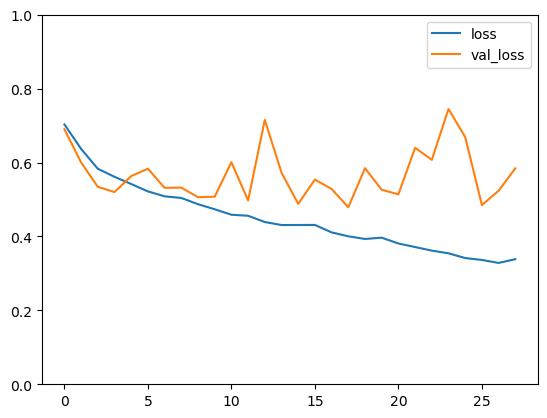

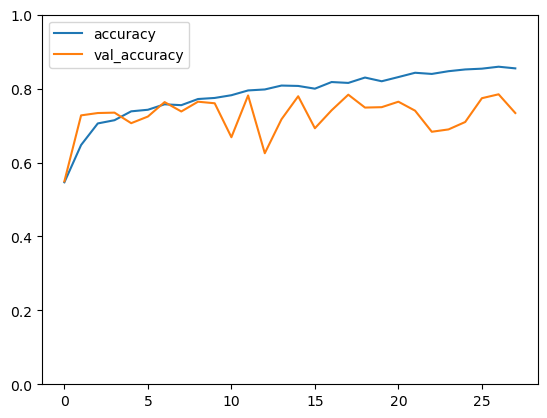

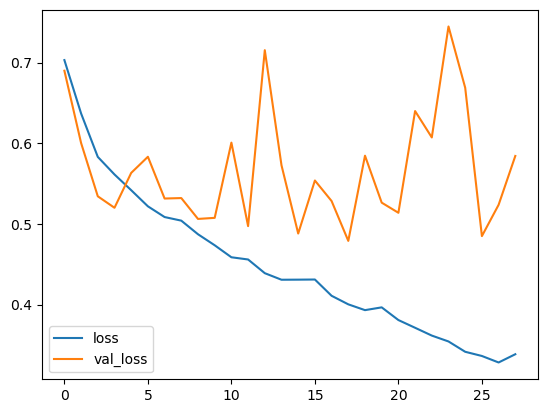

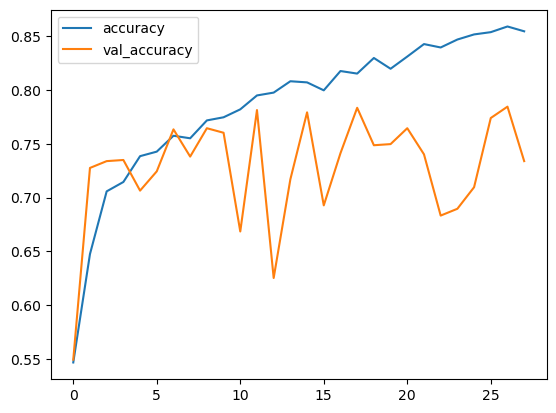

In [5]:
metrics_df1 = pandas.DataFrame(history[0].history)
metrics_df1[["loss", "val_loss"]].plot(ylim=(0, 1))
metrics_df1[["accuracy", "val_accuracy"]].plot(ylim=(0, 1))
metrics_df1[["loss", "val_loss"]].plot()
metrics_df1[["accuracy", "val_accuracy"]].plot()

In [10]:
metrics_df1

,accuracy,loss,val_accuracy,val_loss
0,0.546487,0.703091,0.549102,0.689919
1,0.647385,0.636943,0.727561,0.600338
2,0.705758,0.583122,0.733896,0.534275
3,0.714474,0.561335,0.734953,0.520043
4,0.738510,0.541834,0.706441,0.563277
5,0.742736,0.521861,0.724393,0.583266
6,0.757528,0.508561,0.763464,0.531512
7,0.755151,0.504091,0.738120,0.532079
8,0.771791,0.487234,0.764520,0.506229
9,0.774696,0.473578,0.760296,0.507556


In [7]:
train_dataloader = DataLoader(dataset=train, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(dataset=test, batch_size=16, shuffle=True)

model_generator = NaiveDNNModelFamily()
model_generator.hidden_layers = [
    HiddenLayerStructure(550, None),
    HiddenLayerStructure(550, None),
]

end_model = model_generator.make_model((3, 128, 128))
model_generator.compile_model(end_model, 'SGD')
history = end_model.fit(train_dataloader, validation_data=validation_dataloader, epochs=100,
                        callbacks=[keras.callbacks.EarlyStopping(
                            monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='min'
                        )])

Epoch 1/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 52s 175ms/step - accuracy: 0.5331 - loss: 1.0103 - val_accuracy: 0.6174 - val_loss: 0.6448
Epoch 2/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 52s 175ms/step - accuracy: 0.6553 - loss: 0.6228 - val_accuracy: 0.6334 - val_loss: 0.6196
Epoch 3/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 51s 173ms/step - accuracy: 0.6926 - loss: 0.5797 - val_accuracy: 0.7348 - val_loss: 0.5665
Epoch 4/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 52s 175ms/step - accuracy: 0.7290 - loss: 0.5516 - val_accuracy: 0.7517 - val_loss: 0.5228
Epoch 5/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 52s 175ms/step - accuracy: 0.7383 - loss: 0.5255 - val_accuracy: 0.7660 - val_loss: 0.5112
Epoch 6/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 52s 175ms/step - accuracy: 0.7534 - loss: 0.5122 - val_accuracy: 0.6613 - val_loss: 0.6302
Epoch 7/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 52s 175ms/step - accuracy: 0.7485 - loss: 0.5070 - val_accuracy: 0.7314 - val_loss: 0.5495
Epoch 8/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 52s 176ms/step - accuracy: 0.7688 -

In [9]:
import numpy as np

best_trial_index = np.argmin(history.history['val_loss'])
history.history['val_loss'][best_trial_index]

print(
    f"We expect the model to perform with a {best_expected_val_loss} loss and a {best_expected_val_accuracy} accuracy with early stopping and observed. \n"
    f"a real performance on the full set of with: {history.history['val_loss'][best_trial_index]} loss and {history.history['val_accuracy'][best_trial_index]} accuracy"
)

# Our model is statistically coherent

We expect the model to perform with a 0.4750878870487213 loss and a 0.7790034532546997 accuracy with early stopping and observed. 
a real performance on the full set of with: 0.47855144739151 loss and 0.7854729890823364 accuracy


In [16]:
a = 0
tuner.results_summary()  # Ten best
tuner.get_best_hyperparameters(5)

Results summary
Results in dnn-search/two-layers
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 11 summary
Hyperparameters:
lr: 0.0001
momentum: 0.9
layers: 2
units_0: 1024
dropout_0: False
units_1: 256
Score: 0.4587639272212982

Trial 05 summary
Hyperparameters:
lr: 0.0001
momentum: 0.9
layers: 2
units_0: 2048
dropout_0: False
units_1: 64
Score: 0.46094828844070435

Trial 06 summary
Hyperparameters:
lr: 0.0001
momentum: 0.9
layers: 2
units_0: 512
dropout_0: False
units_1: 32
Score: 0.46519288420677185

Trial 00 summary
Hyperparameters:
lr: 0.0001
momentum: 0.9
layers: 2
units_0: 2048
dropout_0: True
units_1: 128
Score: 0.474356472492218

Trial 07 summary
Hyperparameters:
lr: 0.0001
momentum: 0.9
layers: 2
units_0: 64
dropout_0: False
units_1: 32
Score: 0.474996954202652

Trial 14 summary
Hyperparameters:
lr: 0.0001
momentum: 0.9
layers: 2
units_0: 64
dropout_0: False
units_1: 256
Score: 0.4758829176425934

Trial 09 summary
Hyperparameters:
lr: 0.0001
momentu